<a href="https://colab.research.google.com/github/larissa-rangel/Espectro/blob/main/IndexVegetationDataV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install eemont

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eemont: filename=eemont-0.3.6-py3-none-any.whl size=135742 sha256=2b244cc4218bd004d0932916c1d31eedbdcbe76914cba18f345706ed0acf246d
  Stored in directory: /root/.cache/pip/wheels/c2/79/2c/4fed17c3d3b466bbf4fe5872eec11f189147043b01152a4f75
  Created wheel for ee_extra: filename=ee_extra-0.0.15-py3-none-any.whl size=236756 sha256=755d9ca05d8e951df42b7109f7d3cb95773161ef7d519cba7e6129582f7556df
  Stored in directory: /root/.cache/pip/wheels/29/96/0e/4e36b0dfd85e16867723df739294c0aa45a65b191adac4d959
Successfully built eemont ee_extra


In [ ]:
import ee
from datetime import datetime
import geemap
import matplotlib.pyplot as plt
import eemont
import pandas as pd
import numpy as np
import seaborn as sns

# Trigger the authentication flow.
ee.Authenticate()
# Inicializar a API Earth Engine
ee.Initialize(project = 'mimetic-shape-410218')

In [ ]:
# Carregar a região
regiao = ee.FeatureCollection('projects/ee-l247008/assets/3')

In [15]:
def mask_s2_clouds(image):

  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))

  return image.updateMask(mask).divide(10000).clip(regiao).copyProperties(image, image.propertyNames()).set({'data': image.date().format('YYYY-MM-DD')})

In [16]:
# Carrega uma coleção de imagens
collection = (ee.ImageCollection("COPERNICUS/S2_SR")
              .filterBounds((regiao))
              .filterDate('2017-01-01', '2023-12-31')
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .map(mask_s2_clouds))


# QUANTIDADE DE IMAGENS SEM INTERFERÊNCIA DE NUVEM
print('Imagens sem interferência de nuvens', collection.size().getInfo())

Imagens sem interferência de nuvens 185


In [17]:
# FUNÇÃO PARA CALCULAR O NDVI PARA TODAS AS IMAGENS
def indice1(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# FUNÇÃO PARA CALCULAR O NDMI PARA TODAS AS IMAGENS
def indice2(image):
    ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
    return image.addBands(ndmi)
'''
# FUNÇÃO PARA CALCULAR O EVI PARA TODAS AS IMAGENS
def indice3(image):
    evi = image.expression(
        '2.5*((NIR-RED) / (NIR + 6* RED -7.5 * BLUE +1))',
        {
            'NIR': image.select('B8'),#.divide(10000),
            'RED': image.select('B4'),#.divide(10000),
            'BLUE': image.select('B2')#.divide(10000)
        }
    )
    return image.addBands(evi.rename("EVI"))
'''
# FUNÇÃO PARA CALCULAR O EVI PARA TODAS AS IMAGENS
def indice3(image):
    evi = image.expression(
        '2.5*((NIR-RED) / (NIR + 2.4* RED +1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
        }
    )
    return image.addBands(evi.rename("EVI"))

# FUNÇÃO PARA CALCULAR O NDwI PARA TODAS AS IMAGENS
def indice4(image):
    gndvi = image.normalizedDifference(['B8A', 'B3']).rename('GNDVI')
    return image.addBands(gndvi)

# FUNÇÃO PARA CALCULAR O NDRE PARA TODAS AS IMAGENS
def indice5(image):
    ndre = image.normalizedDifference(['B8', 'B9']).rename('NDRE')
    return image.addBands(ndre)

# APLICAR OS INDICES DE VEGETAÇÃO
collection_scales = collection.map(indice1).map(indice2).map(indice3).map(indice4).map(indice5)

# Mostrar as bandas da primeira imagem
print('Bandas', collection_scales.first().bandNames().getInfo())


Bandas ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'NDVI', 'NDMI', 'EVI', 'GNDVI', 'NDRE']


In [18]:
Map = geemap.Map()

Map.addLayer(regiao, {'color': 'blue'}, 'POA')

Map.centerObject(regiao)

# Adicionar uma camada de NDVI
Map.add_layer(collection_scales.select('NDVI'), {'palette': ['red', 'yellow', 'green'], 'min': -1, 'max': 1},
                 'Sentinel NDVI')

# Adicionar uma camada de EVI
Map.add_layer(collection_scales.select('EVI'), {'palette': ['blue', 'white', 'green'], 'min': -1, 'max': 1},
                 'Sentinel EVI')

# Adicionar uma camada de NDMI
Map.add_layer(collection_scales.select('NDMI'), {'palette': ['purple', 'blue', 'yellow'], 'min': -1, 'max': 1},
                 'Sentinel NDMI')

# Adicionar uma camada de NDWI
Map.add_layer(collection_scales.select('GNDVI'), {'palette': ['purple', 'blue', 'yellow'], 'min': -1, 'max': 1},
                 'Sentinel GNDVI')

# Adicionar uma camada de NDRE
Map.add_layer(collection_scales.select('NDRE'), {'palette': ['purple', 'blue', 'yellow'], 'min': -1, 'max': 1},
                 'Sentinel NDRE')

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [19]:
ts = collection_scales.getTimeSeriesByRegions(collection = regiao,
                                    bands = ['NDVI', 'NDMI', 'EVI', 'GNDVI', 'NDRE'],
                                    reducer = [ee.Reducer.min(), ee.Reducer.mean(), ee.Reducer.max()],
                                    scale = 10)

In [20]:
tsPandas = geemap.ee_to_df(ts)

In [21]:
#tsPandas = geemap.ee_to_df(ts)
tsPandas[tsPandas == -9999] = np.nan
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

In [22]:
tsPandas

,EVI,GNDVI,NDMI,NDRE,NDVI,Name,altitudeMo,begin,date,descriptio,end,extrude,icon,reducer,tessellate,timestamp,visibility
0,0.193496,0.546107,-0.196916,-0.189472,0.316614,3_A,,,2018-12-20 13:57:49,,,0,,min,1,,-1
1,0.239346,0.479492,0.030589,-0.170081,0.385434,3_B,,,2018-12-20 13:57:49,,,0,,min,1,,-1
2,0.122895,0.247644,-0.157895,-0.248564,0.161996,3_C,,,2018-12-20 13:57:49,,,0,,min,1,,-1
3,0.033706,0.126477,-0.368060,-0.379295,0.067021,3_A,,,2019-01-14 13:57:49,,,0,,min,1,,-1
4,0.116522,0.310918,-0.274143,-0.200961,0.217311,3_B,,,2019-01-14 13:57:49,,,0,,min,1,,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,0.717180,0.667478,0.343511,0.122844,0.702554,3_B,,,2023-12-09 13:57:48,,,0,,max,1,,-1
1661,0.724941,0.682404,0.354891,0.173184,0.707608,3_C,,,2023-12-09 13:57:48,,,0,,max,1,,-1
1662,0.625581,0.620579,0.353861,0.137592,0.657238,3_A,,,2023-12-29 13:57:51,,,0,,max,1,,-1
1663,0.577640,0.600232,0.335262,0.078278,0.630851,3_B,,,2023-12-29 13:57:51,,,0,,max,1,,-1


<Axes: xlabel='date', ylabel='Value'>

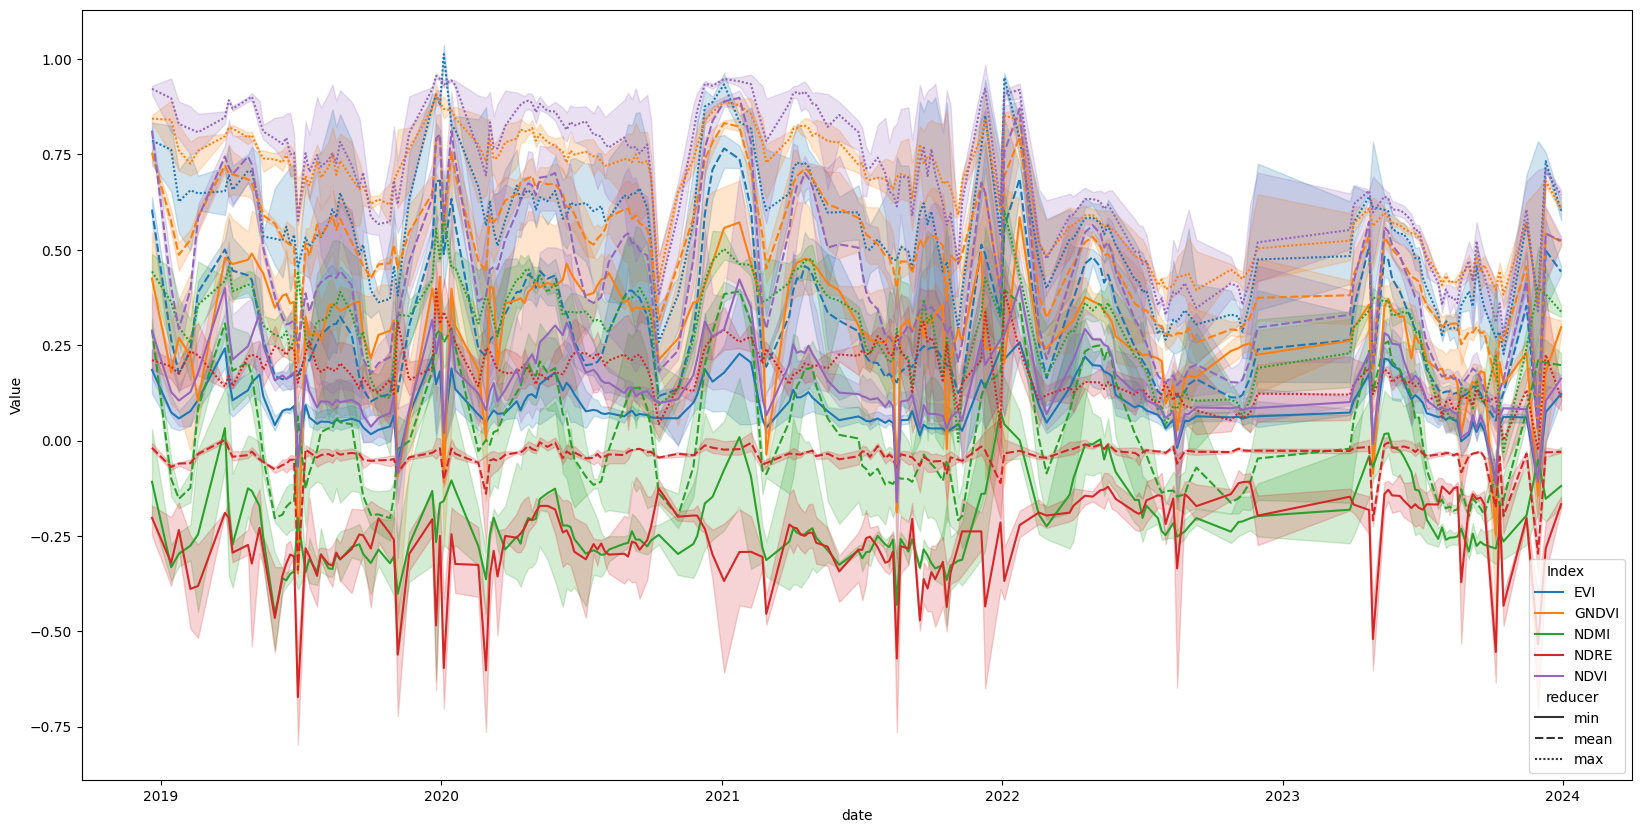

In [23]:
plot = pd.melt(tsPandas,
                   id_vars = ['reducer','date'],
                   value_vars = ['EVI',	'GNDVI',	'NDMI',	'NDRE',	'NDVI'],
                   var_name = 'Index',
                   value_name = 'Value')

plt.figure(figsize = (20,10))
sns.lineplot(data = plot,
             x = 'date',
             y = 'Value',
             hue = 'Index',
             style = 'reducer')